# ADP 실기 26회 머신러닝

## 제품 주문 데이터 세트 : 군집분석(K-means, DBSCAN), 추천 

    - InvoiceNo : 주문번호. ('C'로 시작하는 것은 취소 주문)
    - StockCode : 제품코드(Item Code)
    - Description : 제품 설명
    - Quantity : 주문 제품 건수
    - InvoiceDate : 주문 일자
    - UnitPrice : 제품 단가
    - CustomerID : 고객 번호
    - Country : 국가명(주문 고객의 국적)

- 1-1) 결측치를 확인하고, 결측치 제거할 것
- 1-2) 이상치 제거하는 방법을 설명하고, 이상치 제거하고 난 결과를 통계적으로 나타낼 것
- 1-3) 전처리한 데이터로 Kmeans, DBSCAN 등 방법으로 군집을 생성할 것
<br></br>
- 2-1) 위에서 생성한 군집들의 특성을 분석할 것
- 2-2) 각 군집 별 대표 추천 상품을 도출할 것
- 2-3) CustomerID가 12413인 고객을 대상으로 상품을 추천할 것

In [14]:
# 일단 얘부터 입력 후 시작

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메세지 숨기기
import warnings
warnings.filterwarnings("ignore")

## 1) 데이터 확인 및 전처리 : 제품 주문 데이터 세트
## 1-1) 결측치를 확인하고, 결측치 제거하세요. 

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium
3,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,14646.0,Netherlands
4,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,12583.0,France


In [2]:
df.info() # (35801, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35801 entries, 0 to 35800
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    35801 non-null  object 
 1   StockCode    35801 non-null  object 
 2   Description  35801 non-null  object 
 3   Quantity     35776 non-null  float64
 4   InvoiceDate  35801 non-null  object 
 5   UnitPrice    35704 non-null  float64
 6   CustomerID   35801 non-null  float64
 7   Country      35801 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.2+ MB


#### - 송장 변수(InvoiceNo)에서 맨 앞에 C자가 붙어있는 것은 취소를 의미, 취소된 주문은 제거하는 것이 추후 군집분석에 효율적일 것으로 판단하여 제거

In [3]:
# df 데이터프레임에서 취소된 주문 제거, 데이터가 잘 삭제됐는지 확인
df = df.loc[~df['InvoiceNo'].str.startswith('C')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34805 entries, 0 to 35800
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    34805 non-null  object 
 1   StockCode    34805 non-null  object 
 2   Description  34805 non-null  object 
 3   Quantity     34781 non-null  float64
 4   InvoiceDate  34805 non-null  object 
 5   UnitPrice    34712 non-null  float64
 6   CustomerID   34805 non-null  float64
 7   Country      34805 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


In [4]:
df.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity       24
InvoiceDate     0
UnitPrice      93
CustomerID      0
Country         0
dtype: int64

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,34781.000000,34712.000000,34805.000000
mean,19.241770,4.046057,13222.970924
std,42.127406,37.086676,1012.045952
min,1.000000,0.000000,12354.000000
25%,6.000000,1.250000,12524.000000
50%,12.000000,1.950000,12681.000000
75%,16.000000,3.750000,14156.000000
max,2400.000000,4161.060000,17097.000000


####  Quantity에 25개, UnitPrice에 97개의 결측치가 있음을 확인
#### 결측값을 평균으로 대체 시 이상치의 영향을 받아 데이터가 왜곡될 수 있으므로 median으로 대체하는 방법을 고려했다.

In [6]:
Quantity_median = df["Quantity"].median()
UnitPrice_median = df["UnitPrice"].median()
print(Quantity_median, UnitPrice_median)

df.loc[df["Quantity"].isna()==True,"Quantity"] = Quantity_median
df.loc[df["UnitPrice"].isna()==True,"UnitPrice"] = UnitPrice_median

12.0 1.95


In [7]:
# 결측치 처리 확인
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 1-2) 이상치 제거하는 방법을 설명하고, 이상치 제거하고 난 결과를 통계적으로 나타내세요. 
- 통계적으로 나타내기 위해 boxplot 이용

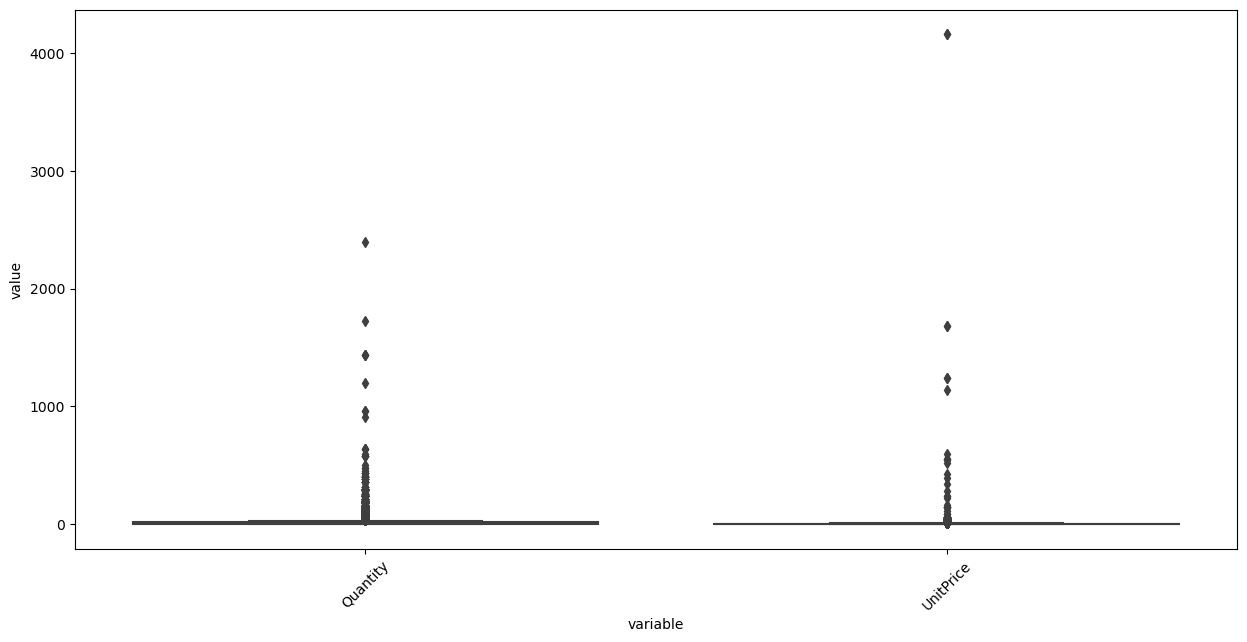

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# boxplot을 그리기 위해 범주형 변수 제거 후 수치형 변수 columns 활용 
X = df[["Quantity", "UnitPrice"]]
df_v1 = pd.melt(X ,var_name='variable', value_name='value')

plt.figure(figsize = (15, 7))
sns.boxplot(x='variable', y='value', data=df_v1)
plt.xticks(range(len(X.columns)), X.columns, rotation=45)
plt.show()

#### boxplot으로 시각화한 결과, Quantity의 경우 이상치로 보이는 값들이 연속적으로 이어져있어 현업 전문가의 의견이 필요할 것으로 판단
#### 일단 Unitprice에서 4000 이상의 확연히 눈에 띄는 이상치만을 처리하도록 결정, 중앙값으로 대체

UnitPrice의 중앙값 : 1.95


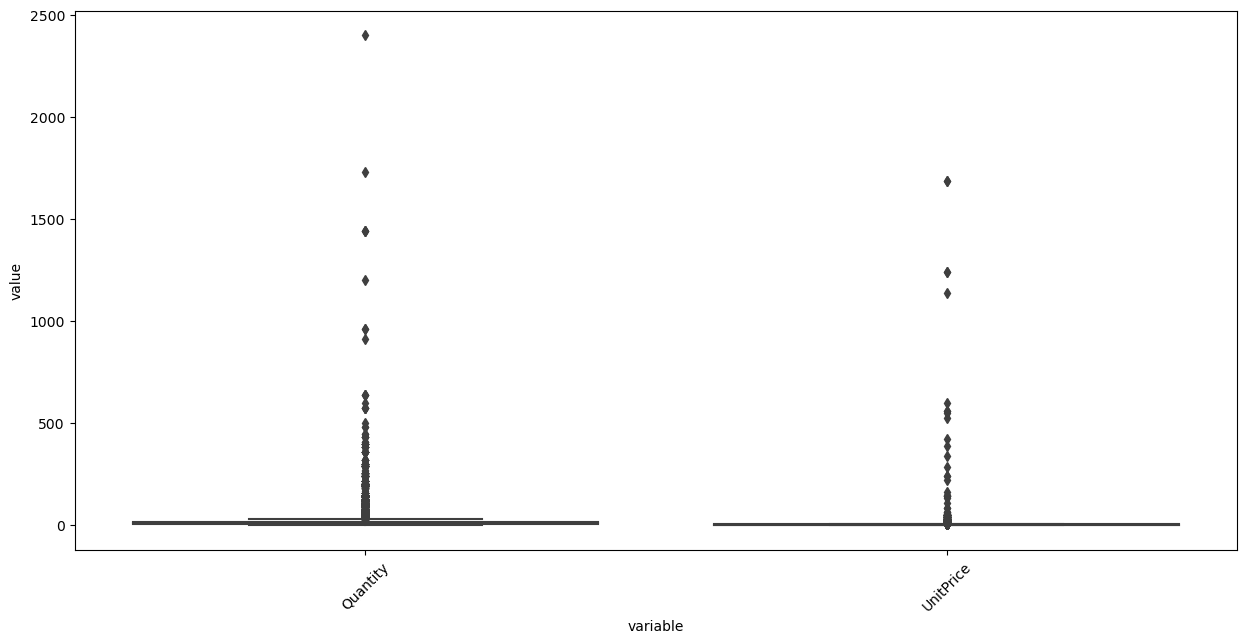

In [9]:
# UnitPrice의 이상치를 중앙값으로 대체
print("UnitPrice의 중앙값 :", df["UnitPrice"].median())
outlier_index = df[df["UnitPrice"]>4000].index

df.loc[outlier_index,"UnitPrice"] = df["UnitPrice"].median()

# Boxplot 생성
X = df[["Quantity", "UnitPrice"]]
df_v1 = pd.melt(X ,var_name='variable', value_name='value')

plt.figure(figsize = (15, 7))
sns.boxplot(x='variable', y='value', data=df_v1)
plt.xticks(range(len(X.columns)), X.columns, rotation=45)
plt.show()

In [10]:
# # 1000 이상 확인 -> 10개 넘음, 이에 대해서도도 추후 논의 필요하다고 판단되어 4000이상만 처리 
# outlier_index_1000 = ML_df[ML_df["UnitPrice"]>1000].index
# outlier_index_1000

In [11]:
# IQR 을 이용한 이상치 탐색 함수

def detect_outliers(df=None, column=None, weight=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    IQR_weight = IQR*weight
    
    outlier_idx = df[(df[column] < Q1 - IQR_weight) | (df[column] > Q3 + IQR_weight)].index
    
    return outlier_idx

In [12]:
# IQR로 이상치를 찾아 인덱스와 개수 확인
out_index_Quantity = detect_outliers(df=df, column='Quantity')
out_index_UnitPrice = detect_outliers(df=df, column='UnitPrice')
print(len(out_index_Quantity), len(out_index_UnitPrice))

3734 4109


- IQR을 이용한 이상치를 고려해봤으나 이상치로 여겨지는 데이터들이 너무 많으므로 boxplot을 이용하여 직관적으로 제거하는 것이 옳다고 판단

## 1-3. 전처리한 데이터로 Kmeans, DBSCAN 등 방법으로 군집을 생성하세요. 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34805 entries, 0 to 35800
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    34805 non-null  object 
 1   StockCode    34805 non-null  object 
 2   Description  34805 non-null  object 
 3   Quantity     34805 non-null  float64
 4   InvoiceDate  34805 non-null  object 
 5   UnitPrice    34805 non-null  float64
 6   CustomerID   34805 non-null  float64
 7   Country      34805 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.4+ MB


#### 범주형 변수 중에서도 고객번호(CustomerID)와 같이 개별적인 식별 정보가 들어간 변수는 군집분석에서 제외하는 것이 옳다고 판단
#### 제품 설명 칼럼(Description)은 제품 코드에 정보가 반영되어있으므로, 군집분석에 불필요하다고 생각되어 포함하지않는 것이 효율적이라고 판단

#### 따라서 본 데이터에서 k-means 군집분석을 수행하기 위한 변수는 아래와 같이 한정
- Quantity : 주문 제품 건수
- UnitPrice : 제품 단가

In [15]:
# 필요한 변수만 추출
clu_df= df[["Quantity", "UnitPrice"]]

In [16]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34805 entries, 0 to 35800
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Quantity   34805 non-null  float64
 1   UnitPrice  34805 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB


### 최적의 군집 개수를 판단하는 방법 : 엘보우 기법
- 클러스터 내 오차제곱합(SSE)를 클러스터 개수마다 비교하는 방법
- 클러스터 개수를 늘려나가면서 계산한 SSE를 비교
- 군집 개수 K개에 따른 오차제곱합을 시각화하여, 오차제곱합이 평평해지기 시작하는 지점(=팔꿈치, elbow)을 K로 지정
- 개수가 늘 때마다 평균값이 급격히 감소하는데 적절한 K가 발견되면 매우 천천히 감소한다.

In [17]:
# 최적 군집 개수 탐색
from sklearn.cluster import KMeans

def elbow(X):
    sse=[]
    for i in range(1, 11):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(X)
        sse.append(km.inertia_)
    
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    print(sse)

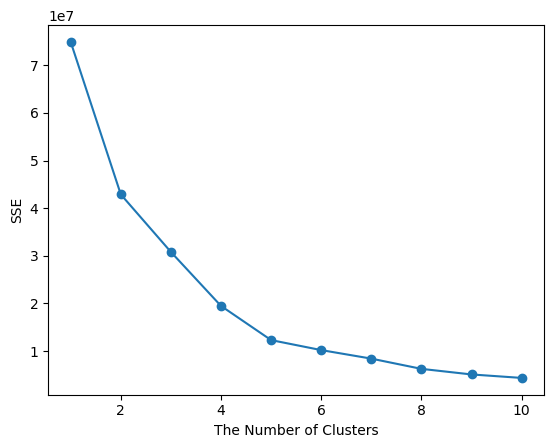

[74905023.79991214, 42875691.03832288, 30792594.204752546, 19457471.334167518, 12279570.66948457, 10181744.942605421, 8389400.78324886, 6238711.5365966465, 5065833.899309986, 4336371.188106602]


In [18]:
elbow(clu_df)

####  엘보우 기법을 적용해, 군집을 4개로 선정하여 군집분석 진행

In [19]:
# K-Means 군집화 실행
km = KMeans(n_clusters = 4, random_state=1)
km.fit(clu_df)

centers = km.cluster_centers_ # 각 군집의 중심점

In [24]:
# 할당된 군집을 원래 데이터에 추가
df['cluster'] = km.labels_
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany,0
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE,0
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium,0
3,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,14646.0,Netherlands,0
4,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,12583.0,France,0
...,...,...,...,...,...,...,...,...,...
35796,554137,21668,RED STRIPE CERAMIC DRAWER KNOB,12.0,5/23/2011 10:13,1.25,12708.0,Germany,0
35797,572986,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,6.0,10/27/2011 10:51,3.25,12681.0,France,0
35798,579927,22734,SET OF 6 RIBBONS VINTAGE CHRISTMAS,6.0,12/1/2011 9:20,2.89,12572.0,Germany,0
35799,551163,22431,WATERING CAN BLUE ELEPHANT,1.0,4/26/2011 15:52,1.95,12573.0,France,0


In [21]:
# 할당된 군집을 데이터에 추가
clu_df['cluster'] = km.labels_
clu_df

,Quantity,UnitPrice,cluster
0,6.0,1.95,0
1,12.0,1.25,0
2,12.0,1.25,0
3,24.0,1.25,0
4,10.0,1.25,0
...,...,...,...
35796,12.0,1.25,0
35797,6.0,3.25,0
35798,6.0,2.89,0
35799,1.0,1.95,0


In [22]:
df["cluster"].value_counts()

0    33189
1     1602
3        9
2        5
Name: cluster, dtype: int64

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 


# 데이터 포인트 마다 실루엣 계수 구하기
cluster_4_silhouette_df = clu_df.copy()

score_samples = silhouette_samples(cluster_4_silhouette_df, clu_df["cluster"])

silhouette_clu = silhouette_samples(clu_df, km.labels_)

# 실루엣 계수 칼럼 추가
clu_df["silhouette_coef"]= score_samples

silhouette_avg = silhouette_score(clu_df, km.labels_) # 각 데이터의 실루엣 계수를 계산
print("실루엣 계수 평균:", silhouette_avg) # 전체 데이터셋의 실루엣 계수 평균을 계산

실루엣 계수 평균: 0.8757597851835844


In [25]:
clu_df.groupby("cluster")["silhouette_coef"].mean()

KeyError: 'Column not found: silhouette_coef'

####  0번 군집에 다량의 데이터가 몰려있는 것을 확인해 실루엣 계수로 군집이 잘 형성되었는지 파악해보았다.
####  실루엣 계수가 1에 가까울수록 각 군집이 잘 형성되었다는 의미로 해석할 수 있고, 평균 실루엣 계수가 0.87로 군집화의 품질이 높다고 평가할 수 있다.

In [ ]:
data = pd.concat([df_F_M_scaled_rm_outlier, pd.DataFrame(kmeans_5.labels_, columns=['label'])], axis=1)

sns.scatterplot(x='Scaled_Freq', 
                y='Scaled_M', 
                hue='label',
                data = data_5)
plt.xlim(-2,3)
plt.ylim(-2,3)

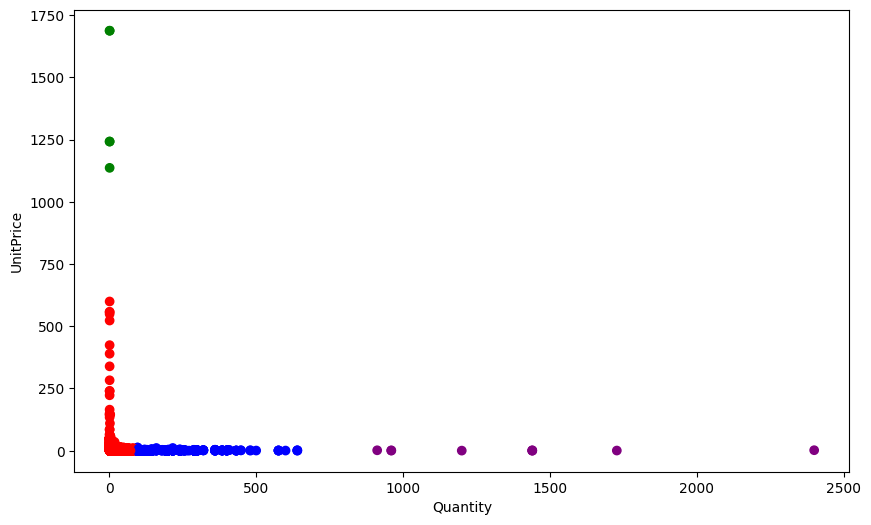

In [35]:
import matplotlib.pyplot as plt

# 산점도 그리기
fig, ax = plt.subplots(figsize=(10, 6))
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}
ax.scatter(clu_df['Quantity'], clu_df['UnitPrice'], c=clu_df['cluster'].map(colors))
ax.set_xlabel('Quantity')
ax.set_ylabel('UnitPrice')
plt.show()


## 2-1) 위에서 생성한 군집들의 특성을 분석할 것

In [30]:
df["cluster"].value_counts()

0    33189
1     1602
3        9
2        5
Name: cluster, dtype: int64

In [31]:
# 각 군집에 대한 특성 분석
cluster_analysis = df.copy()
cluster_analysis.groupby("cluster").mean()

# cluster_analysis.groupby("cluster").agg({"Quantity": ["mean", "max", "min"],
#                                          "UnitPrice": ["mean", "max", "min"]})

C:\Users\36687\AppData\Local\Temp\ipykernel_18256\442678469.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_analysis.groupby("cluster").mean()


,Quantity,UnitPrice,CustomerID
cluster,,,
0,12.562018,3.720554,13173.564886
1,150.002497,1.260594,14239.192884
2,1.000000,1398.920000,13601.000000
3,1386.666667,1.027778,14318.444444


In [32]:
# 군집별로 각 국가의 빈도를 계산
country_counts = df.groupby('cluster')['Country'].value_counts()
country_counts

cluster  Country    
0        Germany        8952
         France         8238
         EIRE           6918
         Spain          2458
         Belgium        2021
         Switzerland    1800
         Portugal       1454
         Netherlands    1348
1        Netherlands    1009
         EIRE            316
         France          102
         Germany          90
         Switzerland      42
         Spain            27
         Belgium          10
         Portugal          6
2        EIRE              2
         Portugal          2
         France            1
3        Netherlands       6
         EIRE              2
         France            1
Name: Country, dtype: int64

#### - 군집의 비율을 보아 군집 2, 3은 각각 원소가 5개, 9개로 매우 적다.  

#### - 군집별 연속형 변수들의 평균값과 군집별로 나타난 국가를 살펴봤을 때, 
- 2번 군집은 단가가 제일 높은 물건을 적은 개수 위주로 구매하는 집단으로 보이며
- 반대로 3번 군집은 단가가 제일 낮지만 다량의 물건을 구매하는 집단으로 보인다. 

- 가장 많은 0번 군집은 독일과 프랑스에서 제일 많이 물건을 구매하는 것으로 보이며, 주 고객층이라고 볼 수 있다. 따라서 추후 주 고객층을 타겟팅하는 전략을 생각해볼 수 있다. 주문 일자 및 기간에 특정한 패턴이 보이는지, 어떤 제품을 특히 많이 구매하는지 추가 분석하여 타겟팅 방법을 구체적으로 고려할 수 있다. 

### 2-2) 각 군집 별 대표 추천 상품을 도출할 것

In [33]:
# 각 군집별 대표 추천 상품 도출
for i in range(4):
    # 해당 군집의 데이터 추출
    cluster_df = df[df['cluster'] == i]
    
    # 군집 별 가장 많이 판매된 제품을 군집의 대표 추천 상품으로 선택
    representative_product = cluster_df['Description'].value_counts().index[0]
    
    # 결과 출력
    print(f"cluster {i} 대표 추천 상품: {representative_product}")

cluster 0 대표 추천 상품: POSTAGE
cluster 1 대표 추천 상품: ROUND SNACK BOXES SET OF4 WOODLAND 
cluster 2 대표 추천 상품: Manual
cluster 3 대표 추천 상품: RABBIT NIGHT LIGHT


### 2-3) CustomerID가 12413인 고객을 대상으로 상품을 추천할 것
- KNN 방법 이용이라고 명시되어있었던 듯
- 혹시 모르니 추천 알고리즘 따로 정리

In [36]:
df_12413 = df.loc[df["CustomerID"]==12413]
df_12413

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster
91,569402,22457,NATURAL SLATE HEART CHALKBOARD,6.0,10/4/2011 9:00,2.95,12413.0,France,0
567,569402,22138,BAKING SET 9 PIECE RETROSPOT,6.0,10/4/2011 9:00,4.95,12413.0,France,0
749,550338,23051,RECYCLED ACAPULCO MAT BLUE,2.0,4/17/2011 15:33,8.25,12413.0,France,0
1683,540365,22750,FELTCRAFT PRINCESS LOLA DOLL,4.0,1/6/2011 16:12,3.75,12413.0,France,0
2349,569402,POST,POSTAGE,1.0,10/4/2011 9:00,18.00,12413.0,France,0
3749,569402,23393,HOME SWEET HOME CUSHION COVER,4.0,10/4/2011 9:00,3.75,12413.0,France,0
4000,569402,23201,JUMBO BAG ALPHABET,10.0,10/4/2011 9:00,2.08,12413.0,France,0
4613,540365,21039,RED RETROSPOT SHOPPING BAG,6.0,1/6/2011 16:12,2.55,12413.0,France,0
4654,540365,21094,SET/6 RED SPOTTY PAPER PLATES,12.0,1/6/2011 16:12,0.85,12413.0,France,0
4965,540365,85014A,BLACK/BLUE POLKADOT UMBRELLA,3.0,1/6/2011 16:12,5.95,12413.0,France,0


In [157]:
customer_id = 12413
customer_orders = df[df['CustomerID'] == customer_id]
product_list = customer_orders['StockCode'].unique()
product_list

array(['22457', '22138', '23051', '22750', 'POST', '23393', '23201',
       '21039', '21094', '85014A', '85099B', '22356', '22504', '22418',
       '21080', '21055', '21086', '21328', '20724', '20750', '22634',
       '22555', '20679', '22617', '22326', '22748', '21936', '21883',
       '22273'], dtype=object)

In [37]:
from sklearn.neighbors import NearestNeighbors

# StockCode와 Quantity 열만 선택
X = df_12413[['StockCode', 'Quantity']]

# KNN 모델 구성
knn_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
knn_model.fit(X)


ValueError: could not convert string to float: 'POST'

In [181]:
# import pandas as pd
# import numpy as np
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# # 고객 ID가 12413인 고객이 이전에 구매한 상품 추출
# customer_orders = df[df['CustomerID'] == 12413]
# product_list = customer_orders['Description'].unique()

# # 추천 상품 개수
# n_recommendations = 5

# # 상품과 수량을 피처 벡터화하여 데이터 프레임 생성
# X = pd.pivot_table(df, values='Quantity', index='StockCode', columns='Description', fill_value=0)

# # 표준화
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # 모델 학습
# model = NearestNeighbors(metric='euclidean', algorithm='kd_tree')
# model.fit(X_std)

# # 추천 상품 탐색
# product_indices = [np.where(X.index == product)[0][0] for product in product_list if product in X.index]
# valid_indices = [idx for idx in product_indices if idx < X.shape[0]]
# if len(valid_indices) > 0:
#     distances, indices = model.kneighbors(X_std[valid_indices], n_neighbors=n_recommendations+1)

#     recommended_products = []
#     for i in range(len(distances)):
#         for j in range(1, len(distances[i])):
#             idx = indices[i][j]
#             recommended_products.append(X.index[idx])

#     # 중복 상품 제거
#     recommended_products = list(set(recommended_products))
# else:
#     recommended_products = []

# print(recommended_products)

[]


In [178]:
# from sklearn.neighbors import NearestNeighbors
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np

# # 고객 ID가 12413인 고객이 이전에 구매한 상품 추출
# customer_orders = df[df['CustomerID'] == 12413]
# product_list = customer_orders['Description'].unique()

# # 유사한 상품 개수
# n_recommendations = 5

# # 피처 벡터화
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(df['Description'].fillna(''))

# # 모델 학습
# model = NearestNeighbors(metric='euclidean', algorithm='kd_tree')
# model.fit(X)

# # 추천 상품 탐색
# product_indices = [np.where(vectorizer.get_feature_names_out() == product)[0][0] for product in product_list if product in vectorizer.get_feature_names_out()]
# valid_indices = [idx for idx in product_indices if idx < X.shape[0]]
# if len(valid_indices) > 0:
#     distances, indices = model.kneighbors(X[valid_indices], n_neighbors=n_recommendations+1)

#     recommended_products = []
#     for i in range(len(distances)):
#         for j in range(1, len(distances[i])):
#             idx = indices[i][j]
#             recommended_products.append(df['Description'][idx])

#     # 중복 상품 제거
#     recommended_products = list(set(recommended_products))
# else:
#     print("해당 고객에게 추천할 상품이 없습니다.")
#     recommended_products = []
    
# print(recommended_products)


해당 고객에게 추천할 상품이 없습니다.
[]


In [141]:
# # CustomerID가 12413인 고객을 대상으로 상품 추천
# customer_data = data[data["CustomerID"] == 12413]
# customer_data["Cluster"] = kmeans.predict(customer_data[["Quantity", "UnitPrice"]])
# customer_cluster = customer_data["Cluster"].value_counts().index[0]
# recommended_product = cluster_representatives[cluster_representatives["Cluster"] == customer_cluster]["Representative"].values[0]

# print("Recommended product for CustomerID 12413: {}".format(recommended_product))